1) Read in the given data (1 Point)

The data describes single cell data. `data.tsv` containes the raw counts, each column describes a single cell and each row describes a gene. `annotation_data.tsv` contains the annotation_data, meaning each cell gets assigned a batch and a group. The batch does not matter, the group does and we will reuse it. The group information from `annotation_data.tsv` has to be mapped to the data in `data.csv`.


In [22]:
import pandas as pd

# Read the raw counts data
data_df = pd.read_csv('data.tsv', sep='\t', index_col=0)

# Read the annotation data
annotation_df = pd.read_csv('annotation_data.tsv', sep='\t', index_col=0)

# Extract the Group information from the Group column -->Specified in the task
group_info = annotation_df['Group']

# Ensure the order of group_info matches the columns in data_df
if not all(data_df.columns == group_info.index):
    raise ValueError("Column order mismatch between data and annotation")

# Transform group_info into a DataFrame row, basically transposing the data as its easier to add it into the Table
group_row = pd.DataFrame([group_info.values], columns=group_info.index)

# Add the group row as the first row in the data_df
data_with_group = pd.concat([group_row, data_df], ignore_index=True)

# Set the index to indicate the first row is 'group'
data_with_group.index = ['Group'] + data_df.index.tolist()

# Optionally, write to a new file or proceed with further analysis
data_with_group.to_csv('processed_data.tsv', sep='\t')

print(data_with_group.head())

        Cell1   Cell2   Cell3   Cell4   Cell5   Cell6   Cell7   Cell8   Cell9  \
Group  Group1  Group1  Group1  Group1  Group1  Group1  Group2  Group1  Group1   
Gene1       0       0       0       0       0       0       0       0       0   
Gene2       0       0       0       0       0       0       0       0       0   
Gene3      69       0       0       0       0       0      49      48       0   
Gene4       0       0       0       0       0       0       0       0       0   

       Cell10  ... Cell4991 Cell4992 Cell4993 Cell4994 Cell4995 Cell4996  \
Group  Group1  ...   Group1   Group1   Group1   Group1   Group1   Group1   
Gene1       0  ...        0        0        0        0        0        0   
Gene2       0  ...        0        0        0        0        0        0   
Gene3       0  ...        0       52        0        0       58        0   
Gene4       0  ...        0        0        0        0        0        0   

      Cell4997 Cell4998 Cell4999 Cell5000  
Group   Grou


2) Check the data for zeros and NAs, check distributions for genes, samples and groups, how many samples and genes do you have, do you have data imbalance between conditions...

Aggregate the data if you want (for example per group) or plot random 10-30.
(3 points)

Total number of zeros in the dataset: 9273231
Total number of NAs in the dataset: 0
Number of genes: 2000
Number of samples: 5000


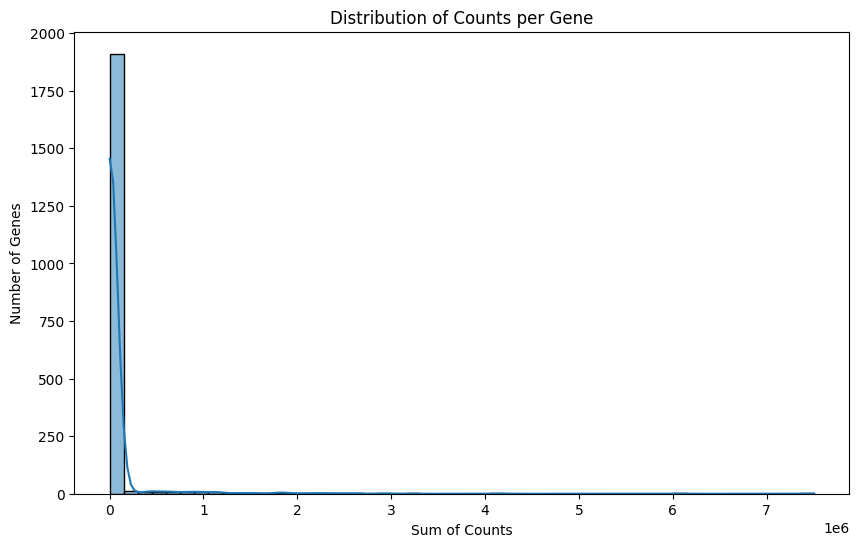

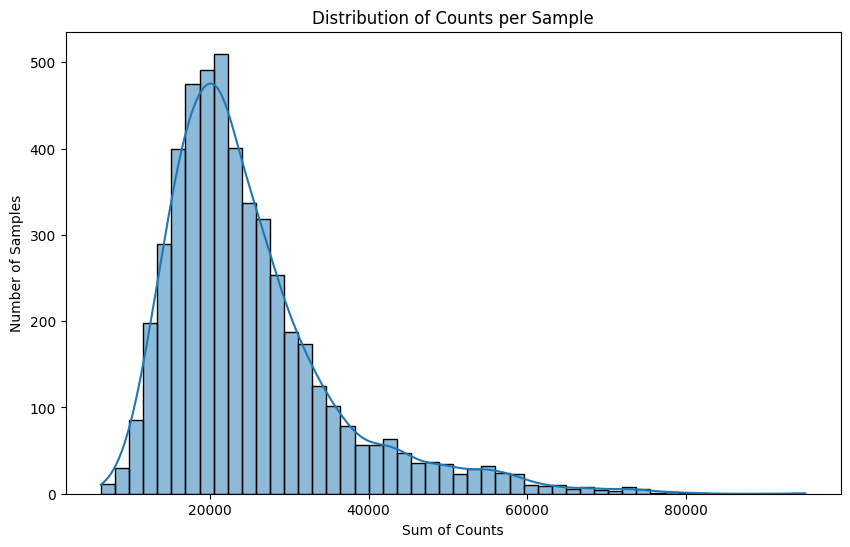

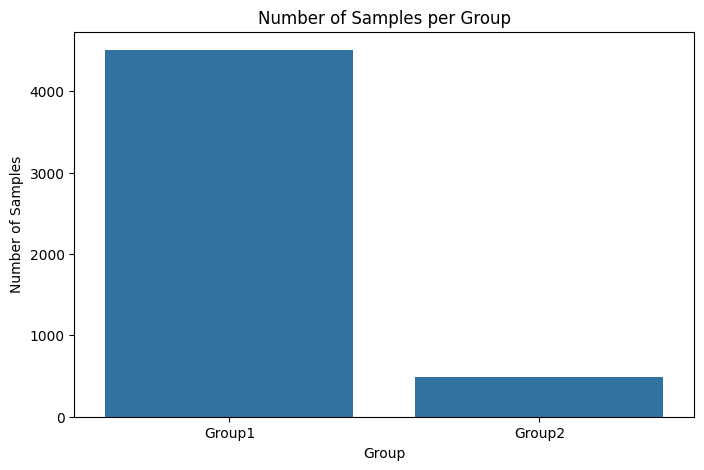

Samples per group:
Group
Group1    4506
Group2     494
Name: count, dtype: int64


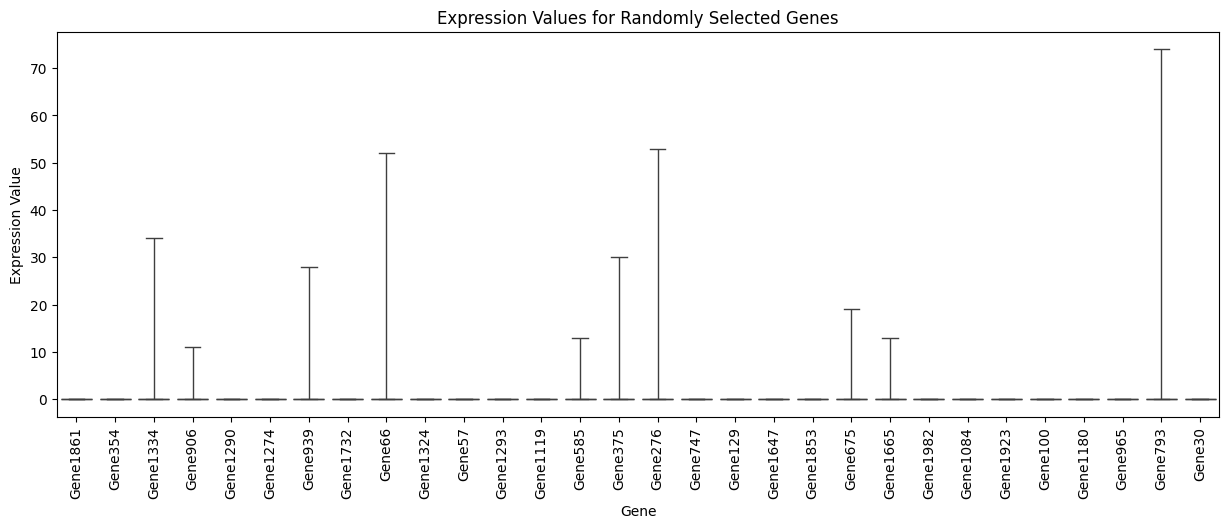

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data with group information included as the first row
# Assuming the data file was processed using the previous instructions
data_df = data_with_group # Just done to work with shorter names, not necessary

# Check for zeros and missing values (NAs)
zero_counts = (data_df == 0).sum().sum()
na_counts = data_df.isna().sum().sum()

print(f"Total number of zeros in the dataset: {zero_counts}")
print(f"Total number of NAs in the dataset: {na_counts}")

# Check distributions for genes, samples, and groups
# Remove the group row from the data for distribution analysis
group_row = data_df.loc['Group']
expression_data = data_df.drop(index='Group')

# Summary statistics
num_genes = expression_data.shape[0]
num_samples = expression_data.shape[1]
print(f"Number of genes: {num_genes}")
print(f"Number of samples: {num_samples}")

# Check the distribution of count data per gene
gene_distribution = expression_data.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(gene_distribution, bins=50, kde=True)
plt.title("Distribution of Counts per Gene")
plt.xlabel("Sum of Counts")
plt.ylabel("Number of Genes")
plt.show()

# Check the distribution of count data per sample
sample_distribution = expression_data.sum(axis=0)
plt.figure(figsize=(10, 6))
sns.histplot(sample_distribution, bins=50, kde=True)
plt.title("Distribution of Counts per Sample")
plt.xlabel("Sum of Counts")
plt.ylabel("Number of Samples")
plt.show()

# Check the distribution of samples per group
group_counts = group_row.value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=group_counts.index, y=group_counts.values)
plt.title("Number of Samples per Group")
plt.xlabel("Group")
plt.ylabel("Number of Samples")
plt.show()

# Check for data imbalance
print("Samples per group:")
print(group_counts)

# Plot a random sample of genes
random_genes = expression_data.sample(n=min(30, num_genes), random_state=42).T
plt.figure(figsize=(15, 5))
sns.boxplot(data=random_genes, whis=[5, 95], showfliers=False)
plt.xticks(rotation=90)
plt.title("Expression Values for Randomly Selected Genes")
plt.xlabel("Gene")
plt.ylabel("Expression Value")
plt.show()

3) Apply a log transform to the data. Then, apply z-score normalization on the log transformed data.

Save the results of the z-score normalization and the pure log-transform in different objects. The z-score normalization should be done per Gene, not per sample, meaning using the mean and sd per Gene.

Note: usually, for differential expression data we don't do z-score normalization since we have two different distributions and want to compare their direct values. In this exercise we still apply it just for learning purposes.

You can use any suitable package for it or base Python.


(2 points)

In [42]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Isolate the expression data from the group annotations
group_info = data_df.loc['Group']
expression_data = data_df.drop(index='Group')

# Ensure the data is in float format to avoid integer operations
expression_data = expression_data.astype(float)

# Apply log transformation using numpy's log1p
log_transformed = np.log1p(expression_data)

# Apply z-score normalization per Gene
# axis=1 means we're calculating mean and std across samples for each gene
zscore_normalized = log_transformed.apply(zscore, axis=1)

# Add the group information back
log_transformed_with_group = pd.concat([group_info.to_frame().T, log_transformed])
zscore_normalized_with_group = pd.concat([group_info.to_frame().T, zscore_normalized])


# Display a few rows of each to confirm transformations
print("Log-transformed data (first few rows):")
print(log_transformed_with_group.head())

print("Z-score normalized data (first few rows):")
print(zscore_normalized_with_group.head())


Log-transformed data (first few rows):
          Cell1   Cell2   Cell3   Cell4   Cell5   Cell6     Cell7    Cell8  \
Group    Group1  Group1  Group1  Group1  Group1  Group1    Group2   Group1   
Gene1       0.0     0.0     0.0     0.0     0.0     0.0       0.0      0.0   
Gene2       0.0     0.0     0.0     0.0     0.0     0.0       0.0      0.0   
Gene3  4.248495     0.0     0.0     0.0     0.0     0.0  3.912023  3.89182   
Gene4       0.0     0.0     0.0     0.0     0.0     0.0       0.0      0.0   

        Cell9  Cell10  ... Cell4991  Cell4992 Cell4993 Cell4994  Cell4995  \
Group  Group1  Group1  ...   Group1    Group1   Group1   Group1    Group1   
Gene1     0.0     0.0  ...      0.0       0.0      0.0      0.0       0.0   
Gene2     0.0     0.0  ...      0.0       0.0      0.0      0.0       0.0   
Gene3     0.0     0.0  ...      0.0  3.970292      0.0      0.0  4.077537   
Gene4     0.0     0.0  ...      0.0       0.0      0.0      0.0       0.0   

      Cell4996 Cell4997 Cell4

4) Repeat basic plots/EDA analysis for normalized data (both versions).
What changed?

Changes: 

Log Transform: 
-Data is more normally distributed by compressing range of particularly larges values, leading to a more stabil variance
-Less variability is also seen in the second plot due do random gene plots tiypically being shown less
Z Transform:
-Distribution of expression values  centers at zero with a standarrd devation of one. identical mean and varicane across different genees

(2 points)

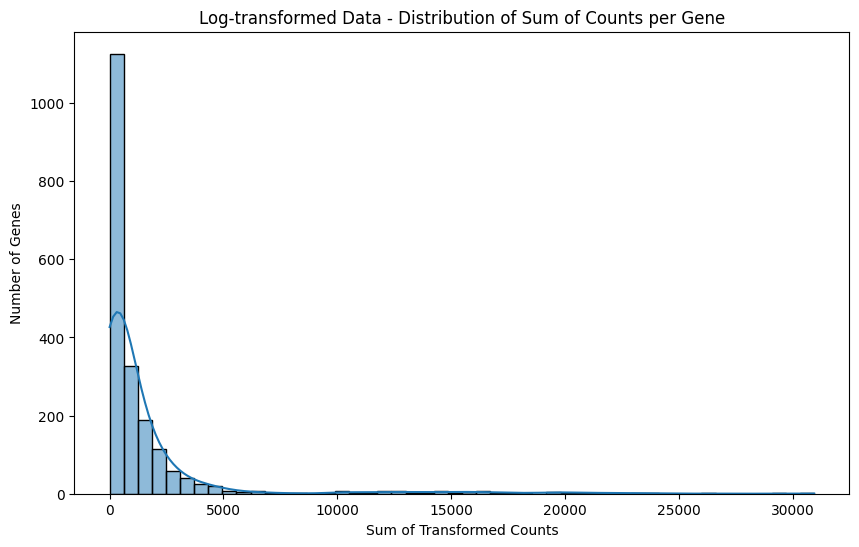

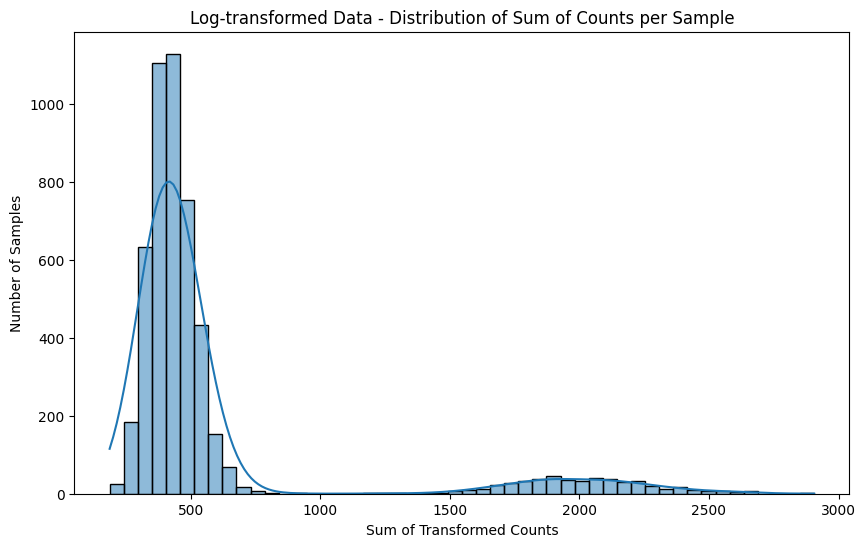

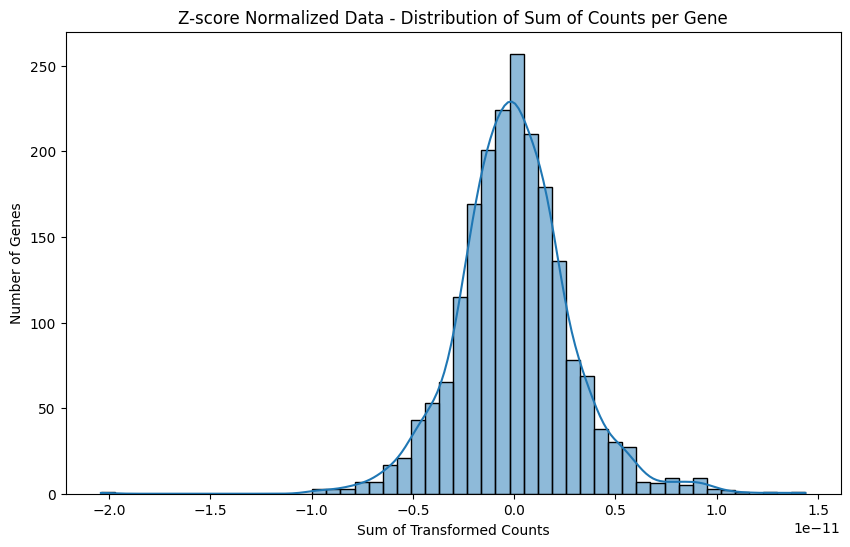

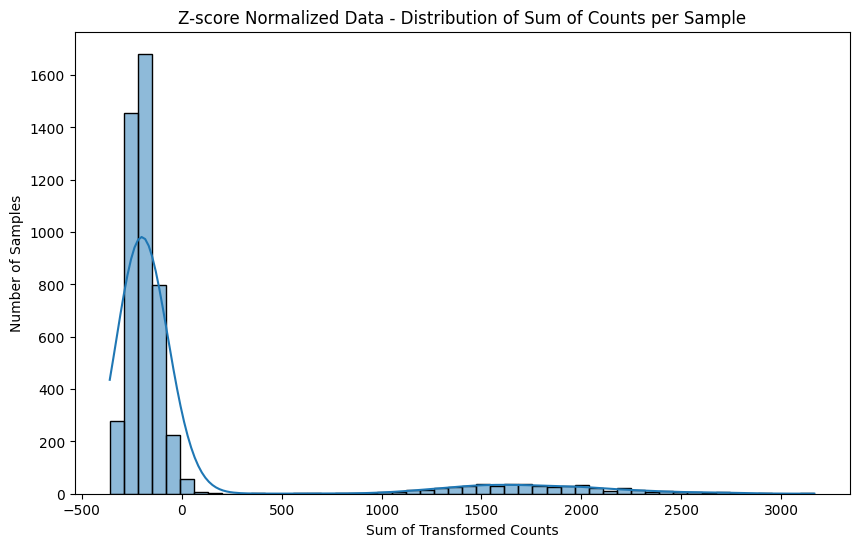

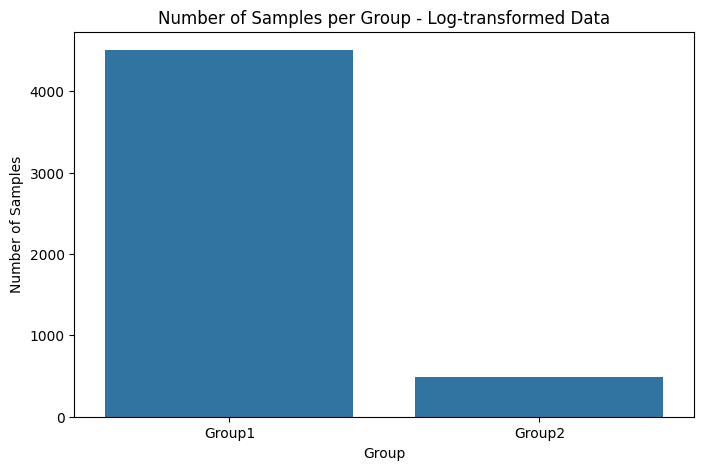

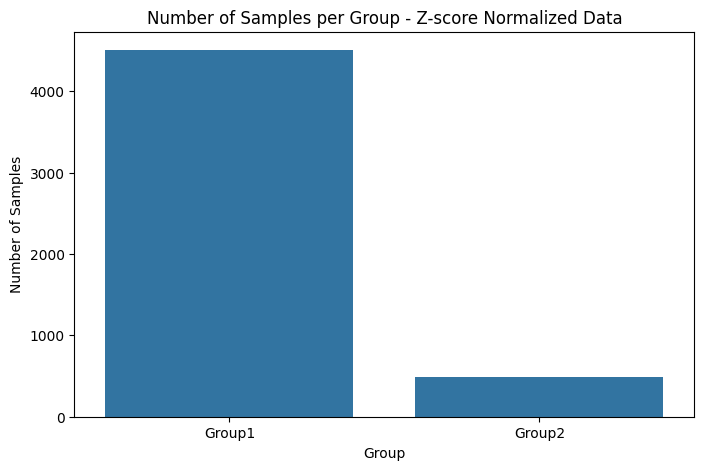

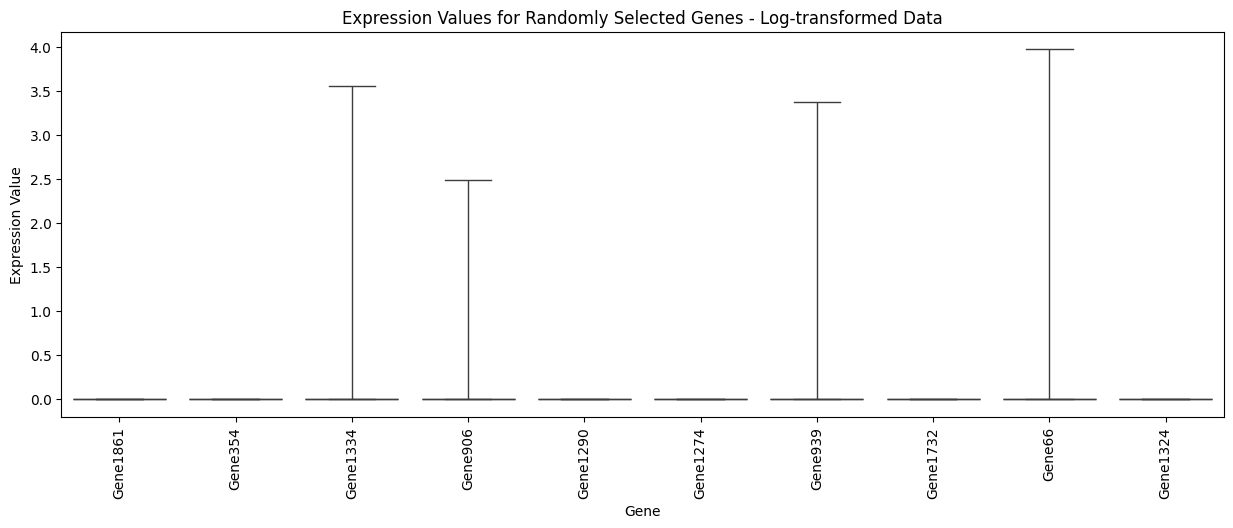

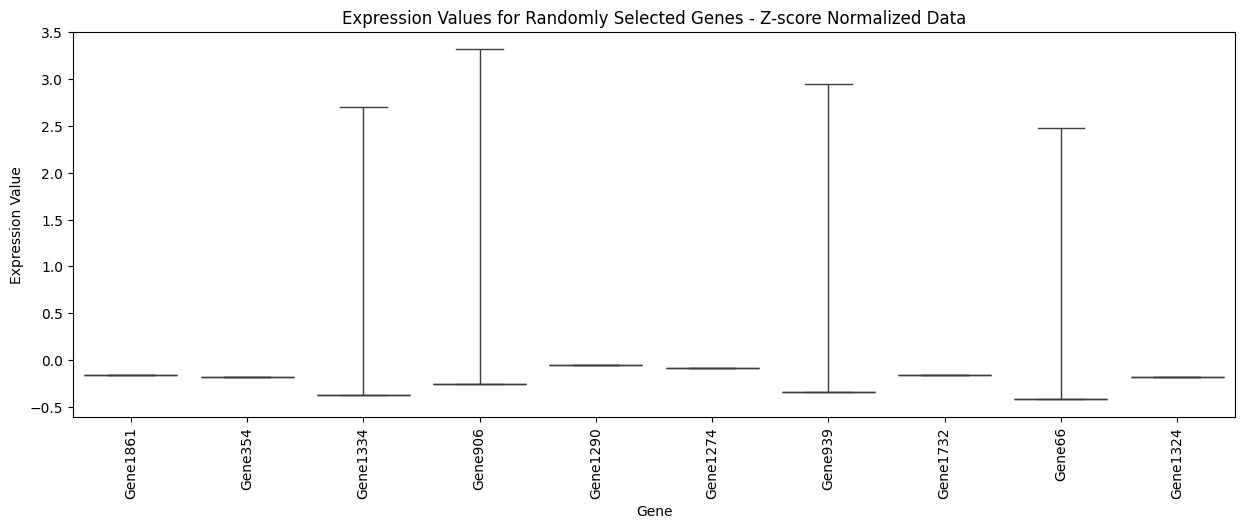

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the group information again
group_info_log = log_transformed_with_group.loc['Group']
expression_log_data = log_transformed_with_group.drop(index='Group')

group_info_zscore = zscore_normalized_with_group.loc['Group']
expression_zscore_data = zscore_normalized_with_group.drop(index='Group')

# Plotting and Analysis
def plot_distributions(expression_data, title_prefix):
    # Distribution of sum of counts per gene
    gene_distribution = expression_data.sum(axis=1)
    plt.figure(figsize=(10, 6))
    sns.histplot(gene_distribution, bins=50, kde=True)
    plt.title(f"{title_prefix} - Distribution of Sum of Counts per Gene")
    plt.xlabel("Sum of Transformed Counts")
    plt.ylabel("Number of Genes")
    plt.show()

    # Distribution of sum of counts per sample
    sample_distribution = expression_data.sum(axis=0)
    plt.figure(figsize=(10, 6))
    sns.histplot(sample_distribution, bins=50, kde=True)
    plt.title(f"{title_prefix} - Distribution of Sum of Counts per Sample")
    plt.xlabel("Sum of Transformed Counts")
    plt.ylabel("Number of Samples")
    plt.show()

# Perform EDA on log-transformed data
plot_distributions(expression_log_data, "Log-transformed Data")

# Perform EDA on z-score normalized data
plot_distributions(expression_zscore_data, "Z-score Normalized Data")

# Check distribution of samples per group again (identical as before since this is unchanged)
def plot_group_distribution(group_info, title):
    group_counts = group_info.value_counts()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=group_counts.index, y=group_counts.values)
    plt.title(title)
    plt.xlabel("Group")
    plt.ylabel("Number of Samples")
    plt.show()

# Plot group distribution (same for both transformations)
plot_group_distribution(group_info_log, "Number of Samples per Group - Log-transformed Data")
plot_group_distribution(group_info_zscore, "Number of Samples per Group - Z-score Normalized Data")

# Random gene sample plot for transformed data
def plot_random_genes(expression_data, title):
    random_genes = expression_data.sample(n=10, random_state=42).T
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=random_genes, whis=[5, 95], showfliers=False)
    plt.xticks(rotation=90)
    plt.title(f"Expression Values for Randomly Selected Genes - {title}")
    plt.xlabel("Gene")
    plt.ylabel("Expression Value")
    plt.show()

plot_random_genes(expression_log_data, "Log-transformed Data")
plot_random_genes(expression_zscore_data, "Z-score Normalized Data")

5) Plot 6 heatmaps in total, for each normalization (z-score, log-transform and raw data) plot both groups seperately.

For each heatmap columns are cells/samples, rows are genes. Don't worry about how the axis text looks, it will definitely look bad since it's so many genes and cells. However, we only want to get a feeling of the difference between the groups as well as of the effects of normalization. For plotting we recommend that you use plotly or seaborn.

(3 Points)

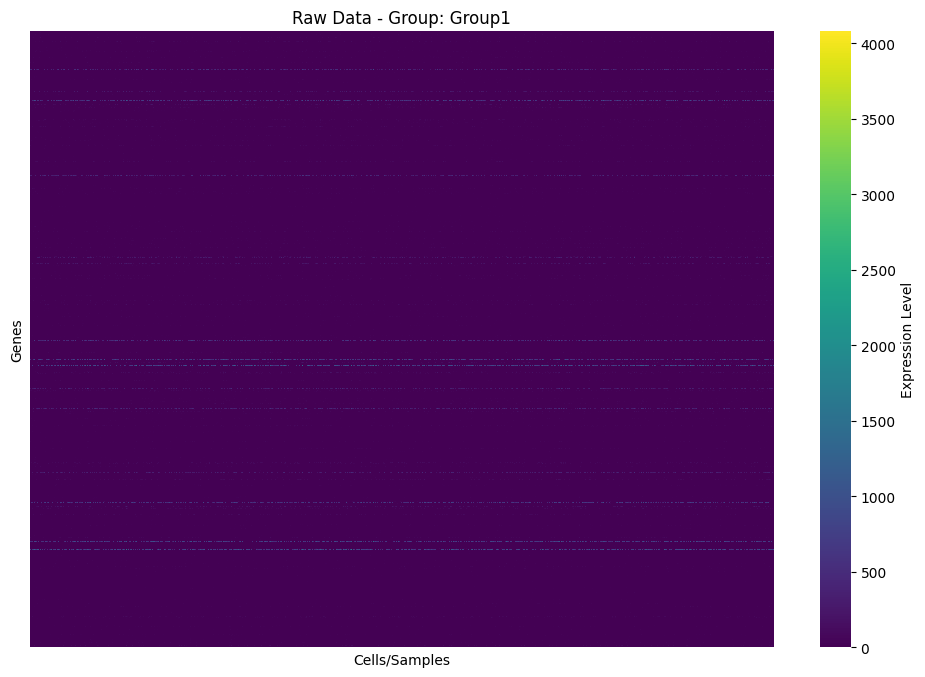

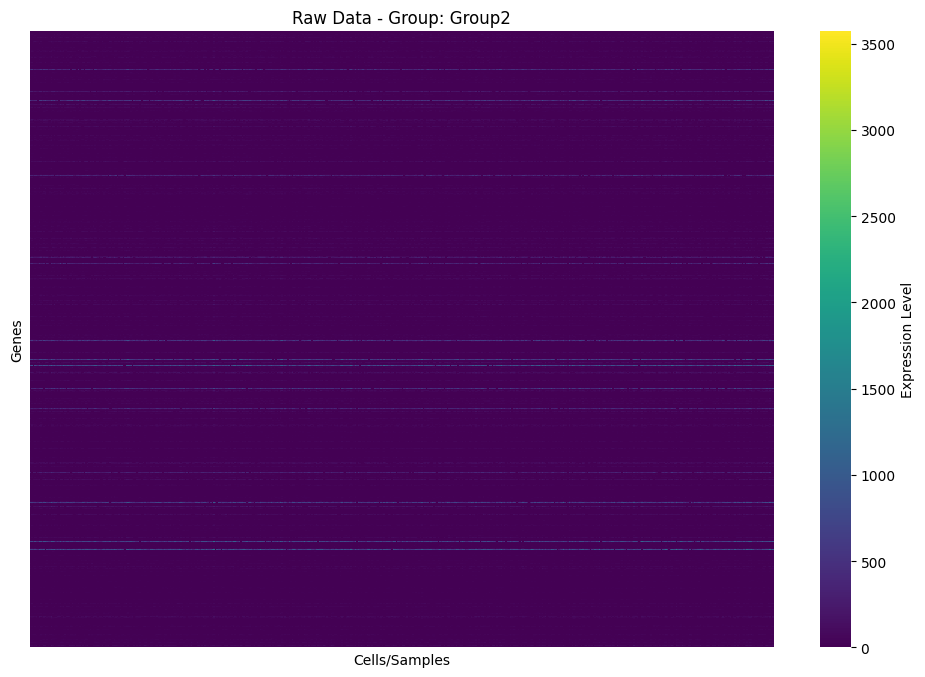

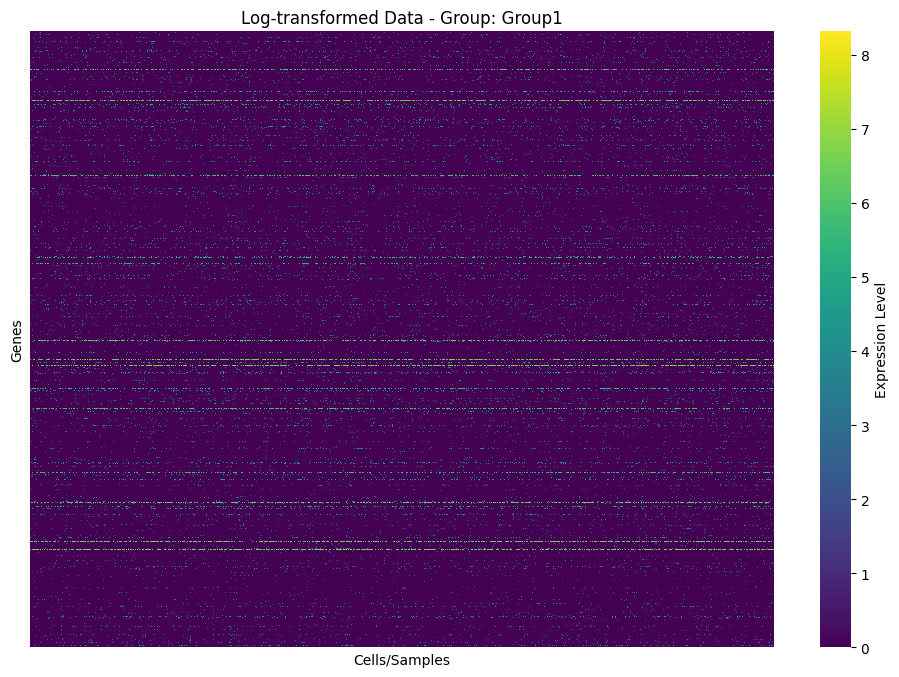

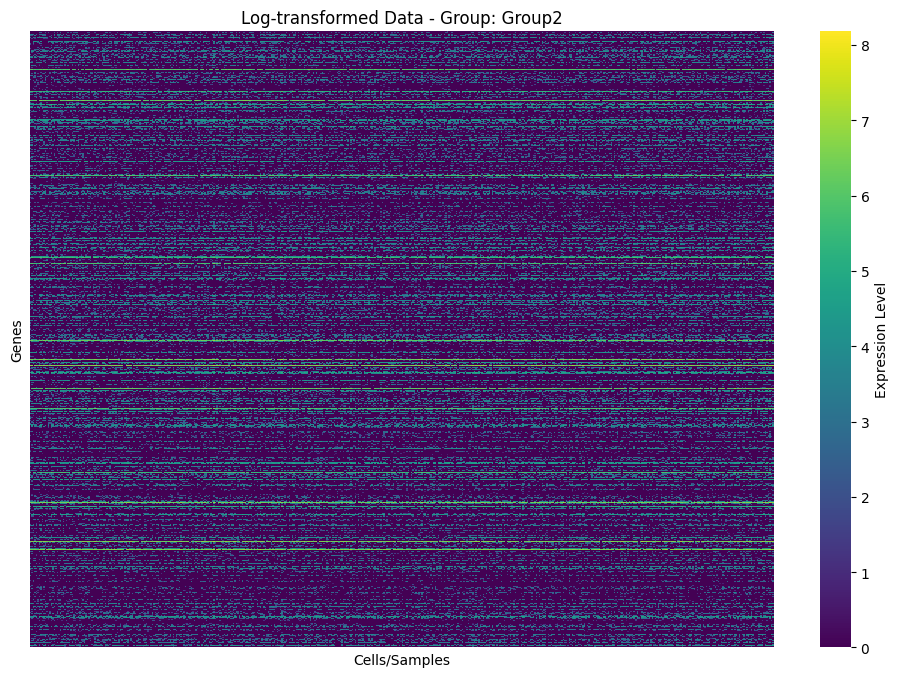

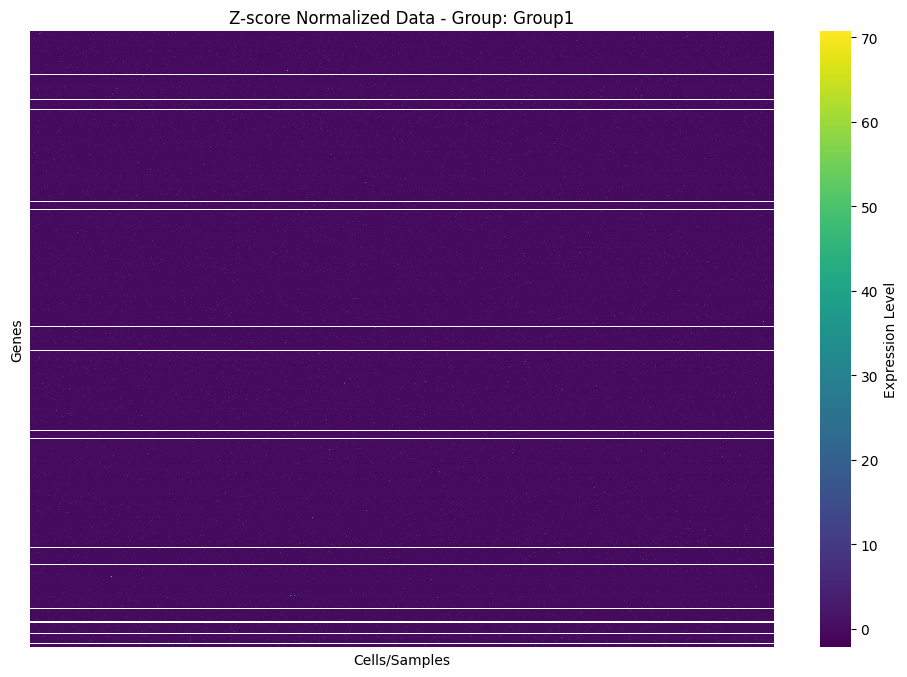

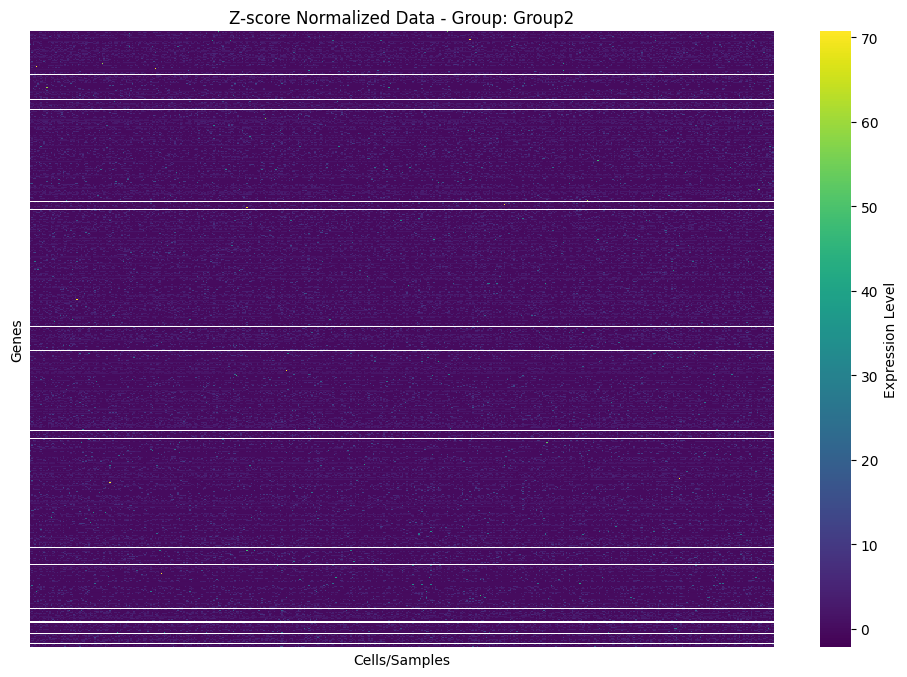

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Extract group information and datasets without group row
group_info_raw = data_with_group.loc['Group']
expression_raw_data = data_with_group.drop(index='Group').astype(float) #I have no idea why a conversion is needed, the error was already in exercise 2 and I dirty fixed it with a forced conversion

group_info_log = log_transformed_with_group.loc['Group']
expression_log_data = log_transformed_with_group.drop(index='Group').astype(float)

group_info_zscore = zscore_normalized_with_group.loc['Group']
expression_zscore_data = zscore_normalized_with_group.drop(index='Group').astype(float)

# Function to plot heatmaps for each group
def plot_heatmaps(expression_data, group_info, title_prefix):
    unique_groups = group_info.unique()
    
    for group in unique_groups:
        group_data = expression_data.loc[:, group_info == group]
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(group_data, cmap='viridis', cbar_kws={'label': 'Expression Level'}, yticklabels=False, xticklabels=False)
        plt.title(f"{title_prefix} - Group: {group}")
        plt.xlabel("Cells/Samples")
        plt.ylabel("Genes")
        plt.show()

# Plot heatmaps for raw data
plot_heatmaps(expression_raw_data, group_info_raw, "Raw Data")

# Plot heatmaps for log-transformed data
plot_heatmaps(expression_log_data, group_info_log, "Log-transformed Data")

# Plot heatmaps for z-score normalized data
plot_heatmaps(expression_zscore_data, group_info_zscore, "Z-score Normalized Data")

6) Apply tSNE and PCA for dimensionality reduction of the given simulated scRNA-seq data.

Plot it for raw, log-transformed and normalized data.

You can use the TSNE class from sklearn.manifold. For PCA, you can use sklearn.decomposition.PCA. You should reduce the dimensionality to only 2 dimensions. (4 Points)

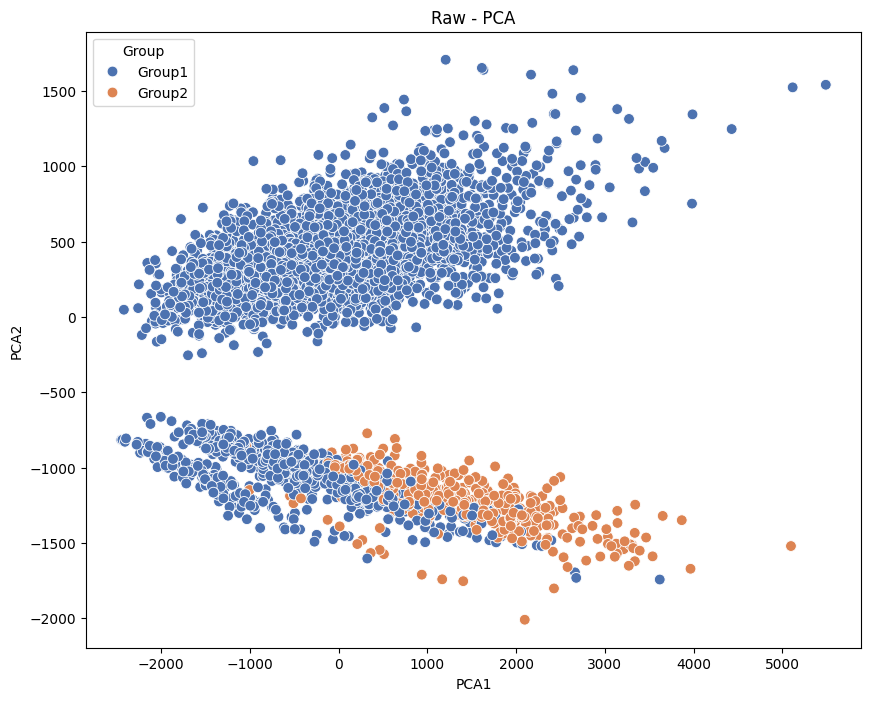

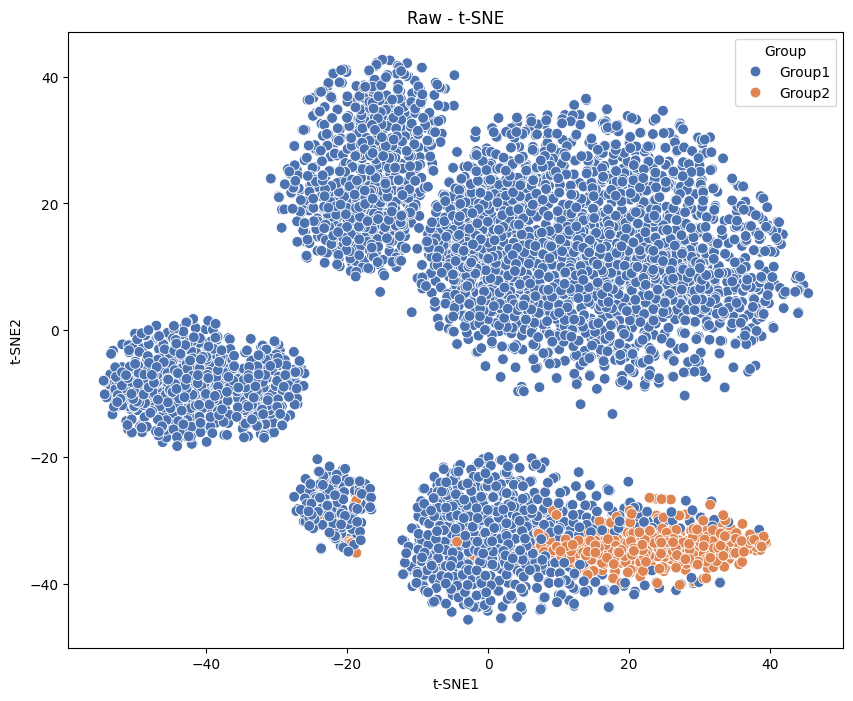

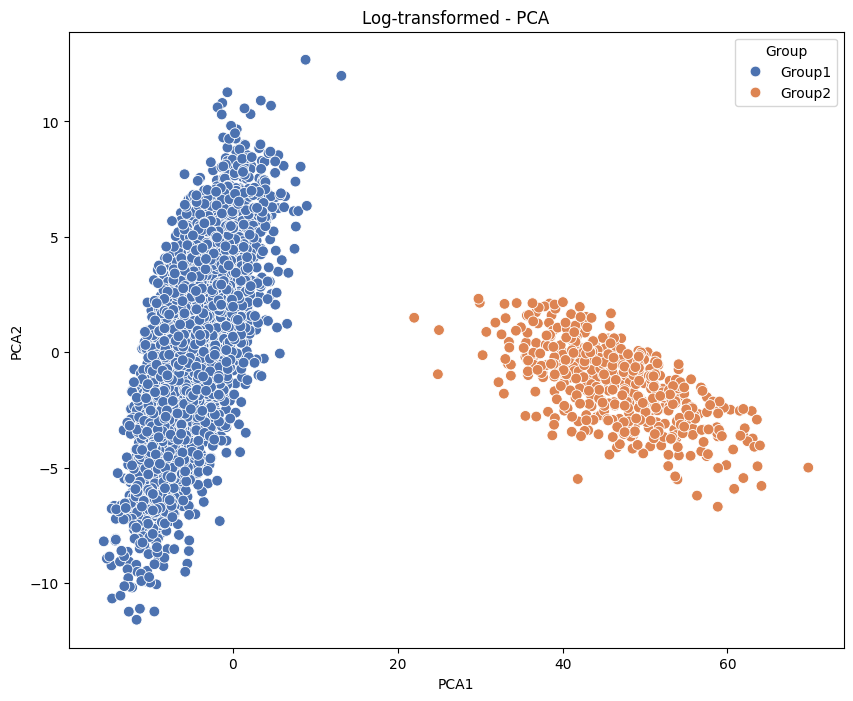

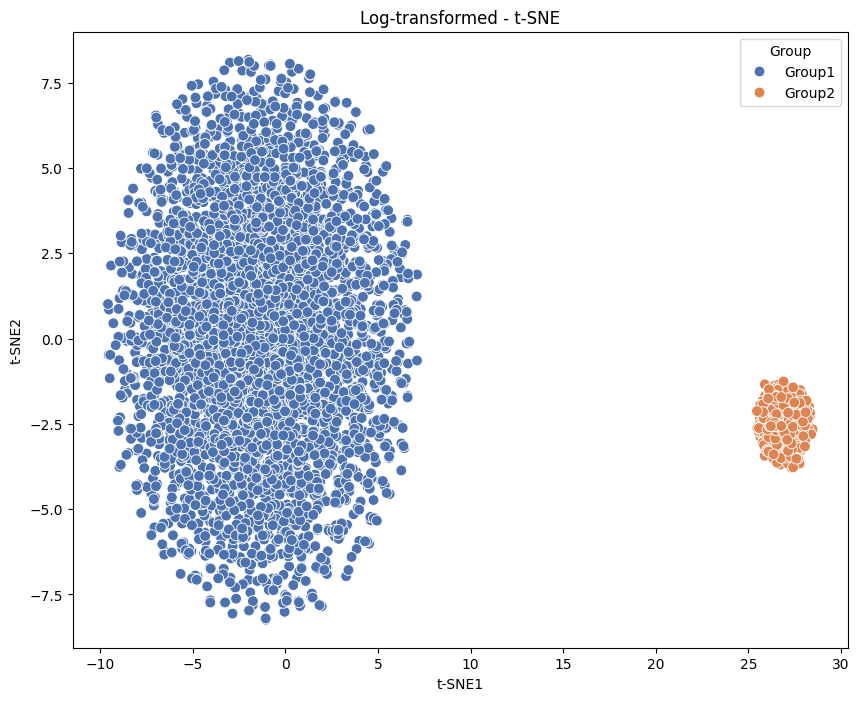

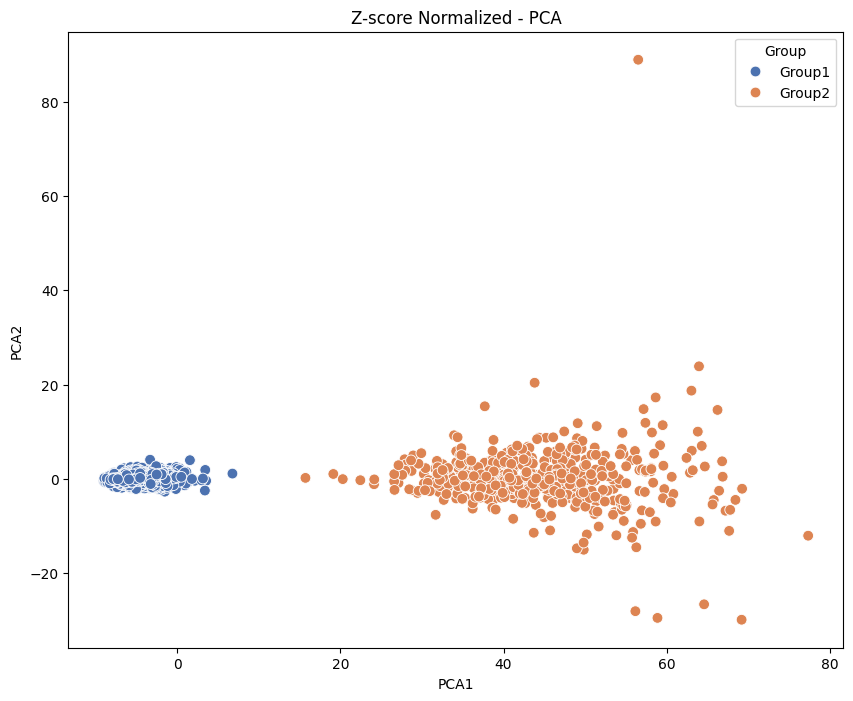

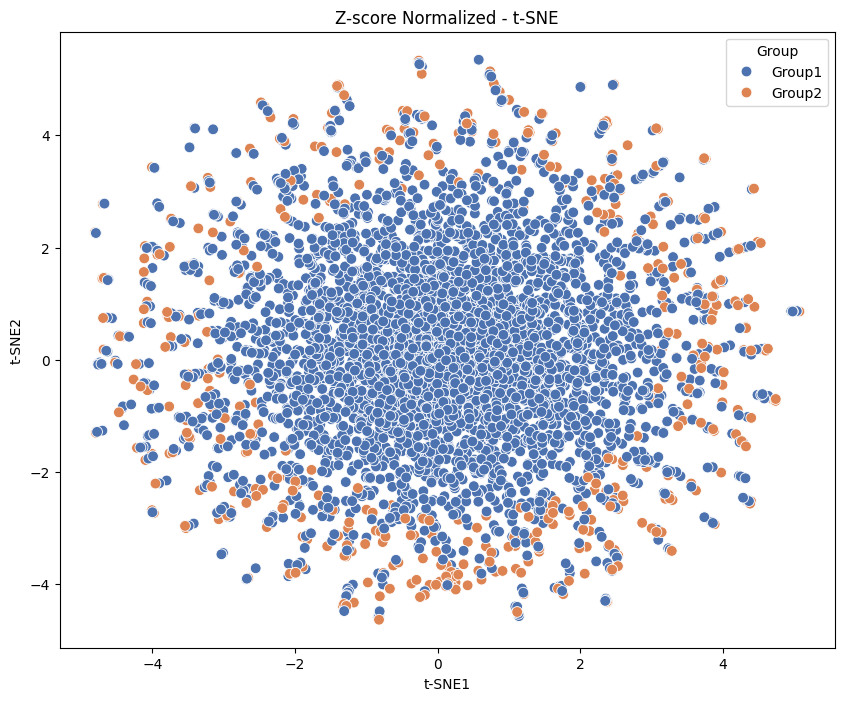

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Load data (assuming data_with_group, log_transformed_with_group, and zscore_normalized_with_group are already defined)
# Example of processing assuming 'Group' annotations in your datasets

# Extract group information and remove the 'Group' row
group_info_raw = data_with_group.loc['Group']
expression_raw_data = data_with_group.drop(index='Group').astype(float).fillna(0)

group_info_log = log_transformed_with_group.loc['Group']
expression_log_data = log_transformed_with_group.drop(index='Group').astype(float).fillna(0)

group_info_zscore = zscore_normalized_with_group.loc['Group']
expression_zscore_data = zscore_normalized_with_group.drop(index='Group').astype(float).fillna(0)

# Function to plot 2D projections
def plot_2d_projection(projection, group_info, method, title_prefix):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=group_info, palette="deep", s=60)
    plt.title(f"{title_prefix} - {method}")
    plt.xlabel(f"{method}1")
    plt.ylabel(f"{method}2")
    plt.legend(title="Group")
    plt.show()

# Apply PCA
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data.T)

# Apply t-SNE
def apply_tsne(data, n_components=2, random_state=0):
    tsne = TSNE(n_components=n_components, random_state=random_state)
    return tsne.fit_transform(data.T)

# Plot each data projection
datasets = {
    "Raw": (expression_raw_data, group_info_raw),
    "Log-transformed": (expression_log_data, group_info_log),
    "Z-score Normalized": (expression_zscore_data, group_info_zscore),
}

for name, (dataset, group_info) in datasets.items():
    # PCA
    pca_projection = apply_pca(dataset)
    plot_2d_projection(pca_projection, group_info, "PCA", name)

    # t-SNE
    tsne_projection = apply_tsne(dataset)
    plot_2d_projection(tsne_projection, group_info, "t-SNE", name)

7) Plot the PCA as well as the tSNE dimensions in two scatter plots for normalized data. Plot the groups in different colours. (2 Points)

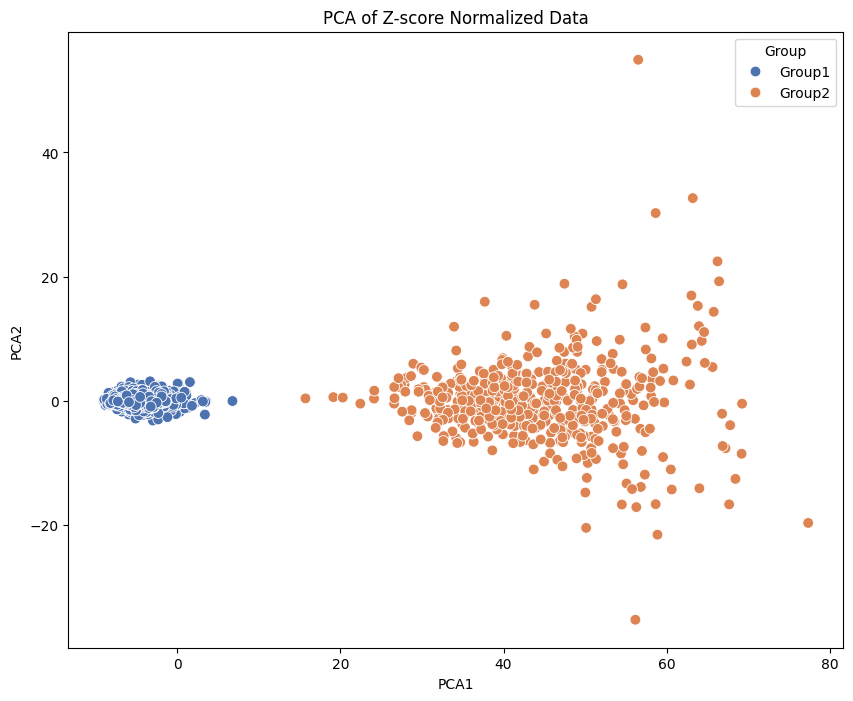

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


# Extract group information and remove the 'group' row
group_info_zscore = zscore_normalized_with_group.loc['Group']
expression_zscore_data = zscore_normalized_with_group.drop(index='Group').astype(float)

# Handle NaN values by filling with zeros
expression_zscore_data = expression_zscore_data.fillna(0)

# Apply PCA to z-score normalized data
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data.T)

# Perform PCA
pca_projection_zscore = apply_pca(expression_zscore_data)

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_projection_zscore[:, 0], y=pca_projection_zscore[:, 1], 
                hue=group_info_zscore, palette="deep", s=60)
plt.title("PCA of Z-score Normalized Data")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Group")
plt.show()

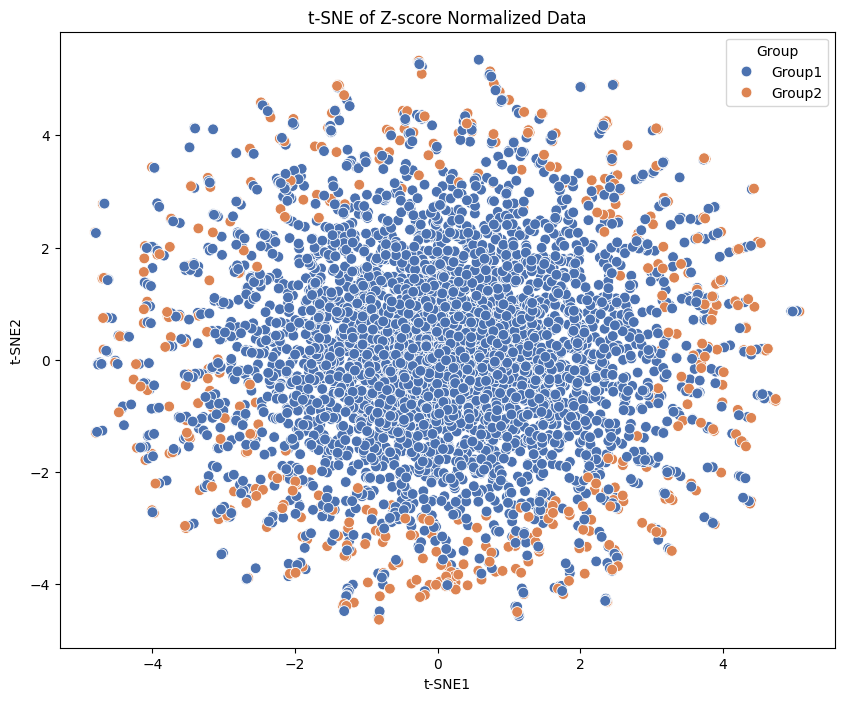

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Extract group information and remove the 'group' row
group_info_zscore = zscore_normalized_with_group.loc['Group']
expression_zscore_data = zscore_normalized_with_group.drop(index='Group').astype(float)

# Handle NaN values by filling with zeros
expression_zscore_data = expression_zscore_data.fillna(0)

# Apply t-SNE to z-score normalized data
def apply_tsne(data, n_components=2, random_state=0):
    tsne = TSNE(n_components=n_components, random_state=random_state)
    return tsne.fit_transform(data.T)

# Perform t-SNE
tsne_projection_zscore = apply_tsne(expression_zscore_data)

# Plot t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_projection_zscore[:, 0], y=tsne_projection_zscore[:, 1], 
                hue=group_info_zscore, palette="deep", s=60)
plt.title("t-SNE of Z-score Normalized Data")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(title="Group")
plt.show()# tSNE